In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties import unumpy as unp
import array_to_latex as a2l
import csv
import pandas as pd
from astropy.io.votable import parse
from astropy.table import QTable, Table, Column
from functools import reduce

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']}) #font na grafih je LaTexov
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{siunitx}')

In [2]:
def f_a (x, I_1, I_0, d): 
    return I_1 * np.cos(x - d) ** 2 + I_0

def f_b (x, I_1, I_0, d):
    return I_1 * np.sin(2 * x - d) ** 2 + I_0

def g(U, I_1, B, fi_0): 
    return I_1 * np.sin((np.pi * B * L / (d ** 2)) + U ** 2 + fi_0 / 2) ** 2

In [3]:
data_a = np.loadtxt('./meritve/1polarizator.txt')

data_a[:, 0] = np.deg2rad(np.arange(0, 95, 5))

data_b = np.loadtxt('./meritve/2polarizatorja.txt')

data_b[:, 0] = np.deg2rad(5) * data_b[:, 0] + np.deg2rad(-90)


In [4]:
par_a, cov_a = curve_fit(f_a, data_a[:, 0], data_a[:, 1])

erra = np.sqrt(np.diag(cov_a))

I_1a = unp.uarray([par_a[0]], [erra[0]])
I_0a = unp.uarray([par_a[1]], [erra[1]])
d_a = unp.uarray([par_a[2]], [erra[2]])


par_b, cov_b = curve_fit(f_b, data_b[:, 0], data_b[:, 1])

errb = np.sqrt(np.diag(cov_b))

I_1b = unp.uarray([par_b[0]], [errb[0]])
I_0b = unp.uarray([par_b[1]], [errb[1]])
d_b = unp.uarray([par_b[2]], [errb[2]])

I_1a * 1e6, I_0a * 1e6, d_a * 180 / np.pi, I_1b * 1e6, I_0b * 1e6, d_b * 180 / np.pi

(array([-255.06935870633+/-4.385196815976497], dtype=object),
 array([257.16617292866346+/-3.2639981805744447], dtype=object),
 array([94.5722966544981+/-1.011700994716615], dtype=object),
 array([-56.4252093845545+/-0.6811659034548622], dtype=object),
 array([57.44735997933964+/-0.42457495593418626], dtype=object),
 array([75.66251781367195+/-0.35078312231786785], dtype=object))

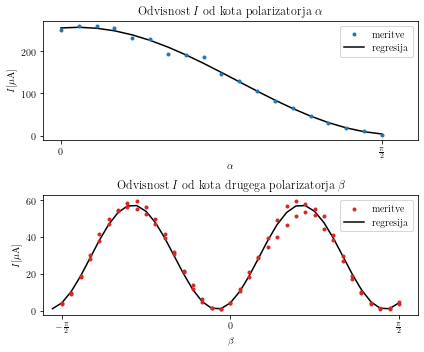

In [5]:
fig, ax = plt.subplots(2, 1, figsize=[6, 5])

ax[0].scatter(data_a[:, 0], data_a[:, 1] * 1e6, marker='.', label='meritve', color='tab:blue')
ax[1].scatter(data_b[:, 0], data_b[:, 1] * 1e6, marker='.', label='meritve', color='tab:red')

x_lin_a = np.deg2rad(np.arange(0, 95, 5))
x_lin_b = np.deg2rad(np.arange(-95, 95, 5))

ax[0].plot(x_lin_a, 1e6 * f_a(x_lin_a, *par_a), color='k', zorder=-1, label='regresija')
ax[1].plot(x_lin_b, 1e6 * f_b(x_lin_b, *par_b), color='k', zorder=-1, label='regresija')

ax[0].set_title(r'Odvisnost $I$ od kota polarizatorja $\alpha$')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$I [\si{\mu A}]$')
ax[0].set_xlim(-np.deg2rad(5), np.deg2rad(100))
ax[0].set_xticks([0, np.pi/2])
ax[0].set_xticklabels([r'$0$', r'$\frac{\pi}{2}$'])
ax[0].legend()

ax[1].set_title(r'Odvisnost $I$ od kota drugega polarizatorja $\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$I [\si{\mu A}]$')
ax[1].set_xlim(-np.deg2rad(100), np.deg2rad(100))
ax[1].set_xticks([-np.pi/2, 0, np.pi/2])
ax[1].set_xticklabels([r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$'])
ax[1].legend()

fig.tight_layout()
fig.savefig('angleofthedangle.pdf')

(array([3.75450437e-04, 9.95876261e-01, 2.39145252e+01]),
 array([ 2.19323294e-04,  1.00842538e+00, -4.67586270e+00]))

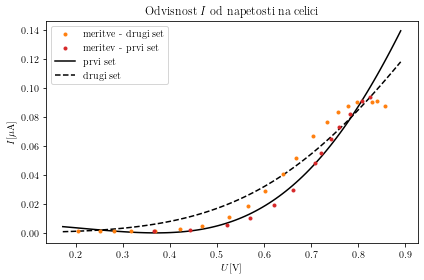

In [6]:
L=1.5e-3
d=1.4e-3

data_c = np.loadtxt('./meritve/3naloga.txt')

del1 = data_c[:13]
del2 = data_c[13:]

fig, ax = plt.subplots()
ax.scatter(del2[:, 0], del2[:, 1] * 1e3, marker='.', label='meritve - drugi set', color='tab:orange')
ax.scatter(del1[:, 0], del1[:, 1] * 1e3, marker='.', label='meritev - prvi set', color='tab:red')

#print(len(del1), len(del2))

U_lin = np.linspace(*ax.get_xlim(), num=101)

par_c1, cov_c1 = curve_fit(g, del1[:, 0], del1[:, 1])

par_c2, cov_c2 = curve_fit(g, del2[:, 0], del2[:, 1])

ax.plot(U_lin, 1e3 * g(U_lin, *par_c1), color='k', linestyle='solid', zorder=-1, label='prvi set')
ax.plot(U_lin, 1e3 * g(U_lin, *par_c2), color='k', linestyle='dashed', zorder=-1, label='drugi set')

ax.set_title(r'Odvisnost $I$ od napetosti na celici')
ax.set_xlabel(r'$U [\si{V}]$')
ax.set_ylabel(r'$I [\si{\mu A}]$')
ax.legend()
fig.tight_layout()
fig.savefig('3naloga.pdf')

par_c1, par_c2